# XG325: Explainable Artificial Intelligence

## Exercise 3

### Load the data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.cluster
import sklearn.decomposition
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

np.set_printoptions(suppress=True)
np.set_printoptions(threshold=10)

%matplotlib inline

In [2]:
# Load the numpy arrays
genetic_fingerprints = np.load('data/ps3/ps3_genetic_fingerprints.npy')
patient_zet = np.load('data/ps3/ps3_patient_zet.npy')

In [3]:
# Display basic information about the arrays
print("Genetic fingerprints shape:", genetic_fingerprints.shape)
print("Genetic fingerprints data type:", genetic_fingerprints.dtype)

print("\nPatient zet shape:", patient_zet.shape)
print("Patient zet data type:", patient_zet.dtype)

Genetic fingerprints shape: (16930, 512)
Genetic fingerprints data type: float32

Patient zet shape: (512,)
Patient zet data type: float32


## Find optimal number of clusters

In [4]:
kmeans = sklearn.cluster.KMeans(n_clusters=2).fit(genetic_fingerprints)
kmeans.inertia_

16042792.0

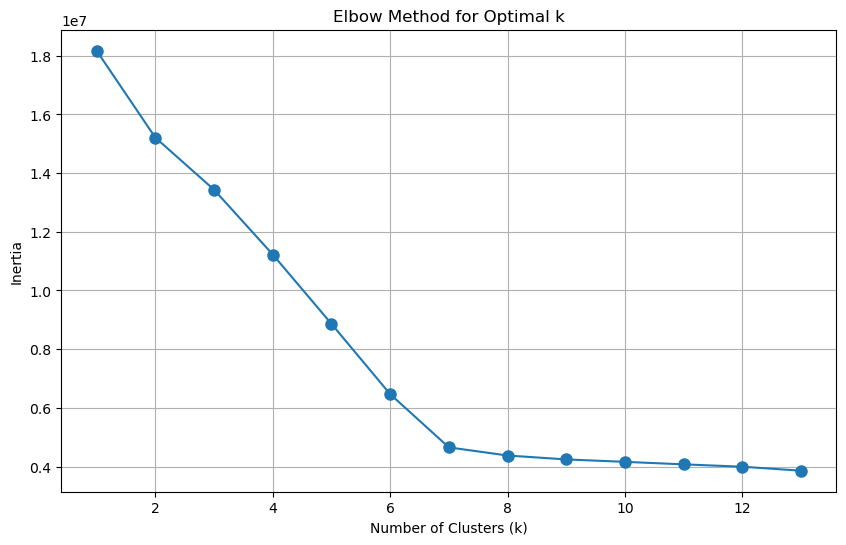

In [5]:
inertia = []
k_range = range(1, 14)

for k in k_range:
    kmeans = sklearn.cluster.KMeans(n_clusters=k, random_state=0, n_init="auto").fit(genetic_fingerprints)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, 'o-', markersize=8)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

## Preprocess the data

In [6]:
# Standardize the data (important for KMeans)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(genetic_fingerprints)

# Reduce dimensions with PCA for better clustering and visualization
pca = PCA(n_components=50)
reduced_data = pca.fit_transform(scaled_data)
print(f"Explained variance ratio: {sum(pca.explained_variance_ratio_):.4f}")

Explained variance ratio: 0.6177


## Apply KMeans

In [7]:
# Apply KMeans with the optimal number of clusters
optimal_k = 7
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(reduced_data)

## Visualize the clusters

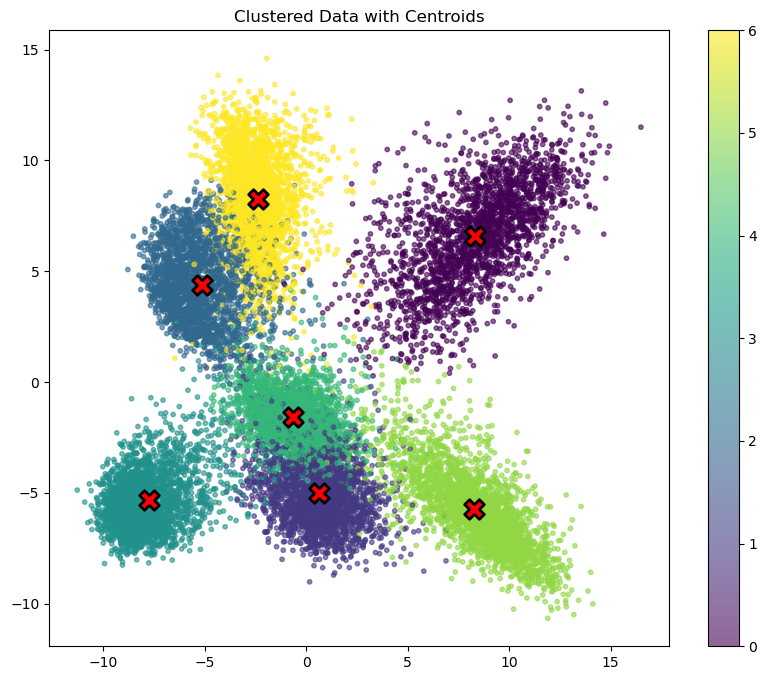

In [8]:
# First, perform PCA reduction to 2D
pca_2d = PCA(n_components=2)
reduced_data_2d = pca_2d.fit_transform(reduced_data)

# Create the scatter plot  
plt.figure(figsize=(10, 8))
scatter = plt.scatter(reduced_data_2d[:, 0], reduced_data_2d[:, 1], c=cluster_labels, cmap='viridis', alpha=0.6, s=10)

# Plot the centroids directly (they're already in 2D)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='X', s=200, linewidths=2, color='red', edgecolor='black')
plt.title('Clustered Data with Centroids')
plt.colorbar(scatter)
plt.show()

## Predict the cluster for patient_zet

In [9]:
# Predict patient_zet's cluster
patient_zet_scaled = scaler.transform(patient_zet.reshape(1, -1))
patient_zet_reduced = pca.transform(patient_zet_scaled)
patient_cluster = kmeans.predict(patient_zet_reduced)[0]
print(f"Patient Zet belongs to cluster: {patient_cluster}")

Patient Zet belongs to cluster: 4


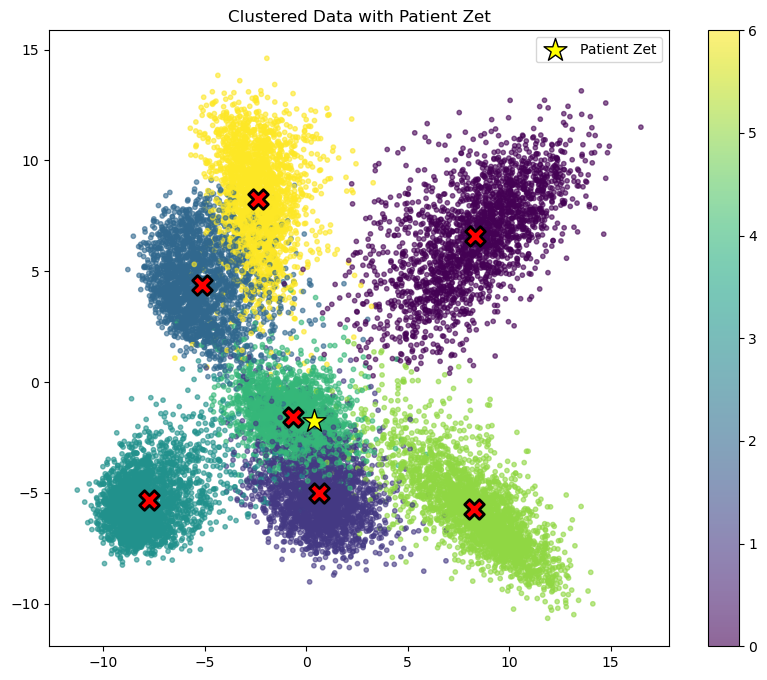

In [10]:
# Reduce patient_zet to 2D for visualization
patient_zet_2d = pca_2d.transform(patient_zet_reduced)

# Create scatter plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(reduced_data_2d[:, 0], reduced_data_2d[:, 1], c=cluster_labels, cmap='viridis', alpha=0.6, s=10)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='X', s=200, linewidths=2, color='red',
            edgecolor='black')

# Add patient_zet point
plt.scatter(patient_zet_2d[0, 0], patient_zet_2d[0, 1], c='yellow', marker='*', s=300, label='Patient Zet',
            edgecolor='black')

plt.title('Clustered Data with Patient Zet')
plt.colorbar(scatter)
plt.legend()
plt.show()

## Kaggle prediction

In [11]:
cluster_labels = kmeans.predict(reduced_data)
patient_zet_cluster = kmeans.predict(patient_zet_reduced)[0]

predictions_cluster = (cluster_labels == patient_zet_cluster).astype(int)

# Count the number of patients in a cluster 4
cluster_4_count = np.sum(cluster_labels == 4)
print(f"Number of patients in cluster 4: {cluster_4_count}")

Number of patients in cluster 4: 2427


In [12]:
import pandas as pd

predictions = predictions_cluster

result_df = pd.DataFrame({
    'Id': np.arange(len(genetic_fingerprints)),
    'Predicted': predictions
})

result_df.to_csv('patient_prediction_results.csv', index=False)